# Дисклеймер
Эту тетрадку лучше запускать в колабе. 

In [3]:
# %pip install --upgrade keras
# %pip install torch torchvision torchaudio

In [9]:
# %pip install scikit-learn pandas matplotlib

## Сверточные нейронные сети

Несколько полносвязных слоев (с нелинейностями посередине) - это уже полноценная нейронная сеть. Однако полносвязный слой это лишь базовый элемент, из которого выстраиваются сложные слои. Сам по себе полносвязный слой обычно встречается только в конце сети, когда нужно получить распределение по классам или итоговое значение (в регрессии). В этом курсе мы разберем три основных типа слоев: сверточные, реккуретные и трасформерные. Все они так или иначе нацелены на учитывание структуры данных. 

В этом семинаре мы попробуем использовать сверточные слои. Лучше всего они работают в картинках (мы до этого тоже дойдем, когда будем разбирать мультимодальные модели), но для текстов их тоже можно применять (они быстрее рекуррентных и могут лучше работать на длинных последовательностях).

Про то как работают сверточные слои посмотрите в этом видео - https://www.youtube.com/watch?v=bNb2fEVKeEo

Основная идея - использовать много небольших (сильно меньше размера текста или картинки) полносвязных слоев и применять каждый маленький полносвязный слой пошагово к отдельным кусочкам векторизованного текста/картинки. Между кусочком и матрицей считается близость (скалярное произведение), и эта близость передается дальше по сети. Т.е. кусочек как-бы **сворачивается** в одно число. 

Эти небольшие матрицы обучаются на данных и, например, для картинок в них собираются различные паттерны, важные для задачи. Например, для определения рукописных цифр, такие матрицы могут представлять горизонтальные черточки, волнистые линии, кружки и т.д. Есть даже целое направление исследований, которое занимается визуализацией и интерпретацией обученных сверток.

Из-за того, что матрицы применяются к кусочкам, а не отедельным элементам, гораздо лучше учитывается структура/последовательность. При этом из-за того, что все применяется не ко всему входу целиком, то получается находить локальные паттерны и находить их независимо от их относительной позиции.

Если это визуалировать, то может показаться, что модель как бы пробегает по картинке/тексту взглядом, при это на каждом шаге фокус очень небольшой и модель не видит то, что вокруг. Каждый маленький полновсвязный ищет взглядом на картинке/тексте что-то свое и, если он это находит, то он активируется. 

![](https://miro.medium.com/v2/resize:fit:1052/0*jLoqqFsO-52KHTn9.gif)

## Классификация с помощью CNN

Давайте посмотрим, как в керасе использовать сверточные сети и как их соединять с Embedding и Dense слоями.

In [224]:
# в новой версии кераса можно использовать разные бекэнды, можно попробовать торч
# если заменить на tensorflow или jax то код также будет работать
# но нужно заранее установить нужный фреймворк
import os
os.environ["KERAS_BACKEND"] = "torch"

In [225]:
import keras
print(keras.__version__)

3.0.4


In [226]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

Возьмем задачу классификации длинных текстов

In [227]:
data = pd.read_csv('../../data/lenta_40k.csv.zip')

In [228]:
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


Предобработка нам тут особо не важна.

In [229]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [230]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [231]:
len(vocab)

354611

In [232]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [233]:
len(filtered_vocab)

24091

In [234]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [235]:
id2word = {i:word for word, i in word2id.items()}

In [236]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [237]:
MAX_LEN = max(len(x) for x in X)

Можно посчитать среднюю или медианную длину, если максимальная кажется слишком большой.

In [238]:
MEAN_LEN = np.median([len(x) for x in X])

In [239]:
MAX_LEN, MEAN_LEN

(1748, 170.0)

In [240]:
MAX_LEN = int(MEAN_LEN + 30)

In [241]:
# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [242]:
X.shape

(44356, 200)

In [243]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [244]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [245]:
len(label2id)

19

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [246]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

Для сравнения сначала обучим сеть только с помощью Dense слоев.

In [247]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )
mean = keras.layers.Flatten()(embeddings)
dense = keras.layers.Dense(30, activation='relu')(mean)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              # фмеры тут нет, но есть точность и полнота по отдельности, 
              # name тут нужен для удобства,
              # иначе метрика будет называться типа "Precision_i"
              # и придется менять i в дальнейших визуализациях 
              metrics=[keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall')])



In [248]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 2.7833 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3901 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 2.3085 - precision: 0.0691 - recall: 3.5167e-05 - val_loss: 2.1125 - val_precision: 0.6250 - val_recall: 0.0090
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 2.0125 - precision: 0.6271 - recall: 0.0156 - val_loss: 1.7982 - val_precision: 0.6579 - val_recall: 0.0564
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 1.6823 - precision: 0.7439 - recall: 0.0935 - val_loss: 1.4435 - val_precision: 0.7756 - val_recall: 0.2665
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 1.3274 - precision: 0.8367 - recall: 0.3543 - val_loss: 1.1843 - val_precision: 0.8284 - val_recall: 0.4635
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 1.0646 - precision: 0.8654 - recall: 0.5189 - val_loss: 1.0376 - val_precision: 0.8244

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])


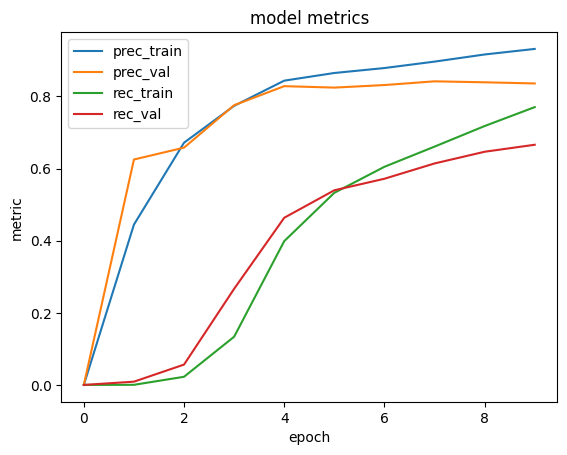

In [249]:
print(model.history.history.keys())
plt.plot(model.history.history['precision'])
plt.plot(model.history.history['val_precision'])
plt.plot(model.history.history['recall'])
plt.plot(model.history.history['val_recall'])
plt.title('model metrics')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['prec_train', 'prec_val', 'rec_train', 'rec_val'], loc='upper left')
plt.show()

А теперь попробуем со сверточным слоем. В керасе они называются Conv1D (2D тоже есть, они используются для картинок). Их нужно ставить сразу после Embedding слоя.

In [250]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

# все остальное точно такое же
# возвращает сверточный слой тоже последовательность векторов слегка измененной или такой же длины
conv1 = keras.layers.Conv1D(kernel_size=10, filters=128, strides=5)(embeddings)

# выход со сверточного слоя также можно просто конкатенировать
concat = keras.layers.Flatten()(conv1)
dense = keras.layers.Dense(64, activation='relu')(concat)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              # еще есть метрика полнота при пороге точности 
              # она очень удобная потому что обычно к модели есть требование минимальной точности
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [251]:
model.summary()

Model: "functional_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_55 (InputLayer)     │ (None, 200)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ embedding_55 (Embedding)        │ (None, 200, 30)           │    722,760 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_139 (Conv1D)             │ (None, 39, 128)           │     38,528 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_54 (Flatten)            │ (None, 4992)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_108 (Dense)               │ (None, 64)                │    319,552 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_109 (Dense)               │ (None, 19)                │      1,235 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,082,075 (4.13 MB)

 Trainable params: 1,082,075 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

In [252]:
# # как выглядит ошибка при слишком большом батче
# model.fit(X_train, y_train, 
#           validation_data=(X_valid, y_valid),
#           batch_size=100000,
#          epochs=5)

In [253]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=5)

Epoch 1/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 298ms/step - loss: 2.6003 - rec@prec: 1.8939e-06 - val_loss: 1.9493 - val_rec@prec: 0.0000e+00
Epoch 2/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 293ms/step - loss: 1.8025 - rec@prec: 0.0306 - val_loss: 1.3537 - val_rec@prec: 0.2453
Epoch 3/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 298ms/step - loss: 1.1847 - rec@prec: 0.4277 - val_loss: 0.9688 - val_rec@prec: 0.6118
Epoch 4/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step - loss: 0.7213 - rec@prec: 0.7637 - val_loss: 0.9064 - val_rec@prec: 0.6569
Epoch 5/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 307ms/step - loss: 0.4891 - rec@prec: 0.8862 - val_loss: 0.9612 - val_rec@prec: 0.6519


dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


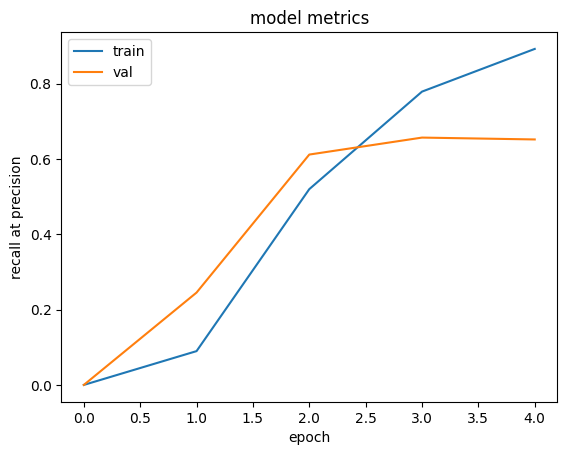

In [254]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Сверточные слои можно накладывать друг на друга.

Давайте еще разберем параметры:  
    **kernel_size** - это размер кусочков, к которым мы применяем сверточные матрицы (похоже на размер нграмма)   
    **filters** - количество матриц свертки  (это как бы размерность до которой будет сжат или развернут вектор)    
    **stride** - шаг по которому выбираются кусочки из последовательности (это как параметр шаг в функции range в питоне)  

In [255]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
conv1 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(embeddings)
conv2 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv1)
concat = keras.layers.Flatten()(conv2)
dense = keras.layers.Dense(64, activation='relu')(concat)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [256]:
model.summary()

Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_56 (InputLayer)     │ (None, 200)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ embedding_56 (Embedding)        │ (None, 200, 100)          │  2,409,200 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_140 (Conv1D)             │ (None, 196, 32)           │     16,032 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_141 (Conv1D)             │ (None, 192, 32)           │      5,152 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_55 (Flatten)            │ (None, 6144)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_110 (Dense)               │ (None, 64)                │    393,280 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_111 (Dense)               │ (None, 19)                │      1,235 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,824,899 (10.78 MB)

 Trainable params: 2,824,899 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

In [257]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
          epochs=10)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 2.5647 - rec@prec: 0.0000e+00 - val_loss: 2.2348 - val_rec@prec: 0.0050
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 2.1296 - rec@prec: 8.0815e-04 - val_loss: 1.8257 - val_rec@prec: 0.0311
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 1.6608 - rec@prec: 0.1364 - val_loss: 1.3158 - val_rec@prec: 0.4874
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 1.0958 - rec@prec: 0.5812 - val_loss: 0.9507 - val_rec@prec: 0.6177
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 0.6956 - rec@prec: 0.7891 - val_loss: 0.9234 - val_rec@prec: 0.6569
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 0.4638 - rec@prec: 0.9032 - val_loss: 0.9551 - val_rec@prec: 0.6668
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 0.3010 - rec@prec: 0.9578 - val_loss: 1.0078 - val_rec@prec: 0.6785
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 0.1856 - rec@prec: 0.9857 - val_loss: 1.1159 - val_r

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


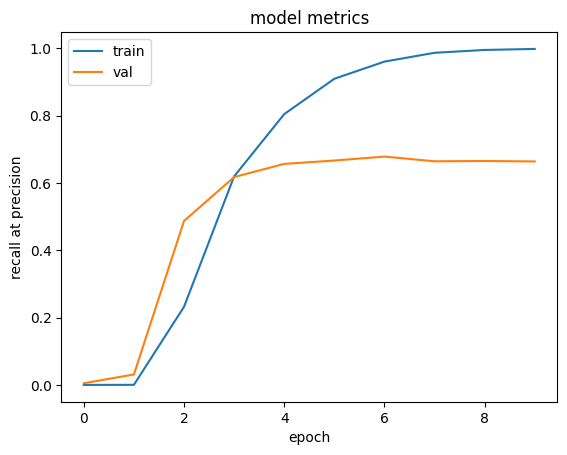

In [258]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Со сверточными слоями часто используется Pooling. Это тоже своего рода свертка, но без обучаемых параметров. В пулингах используется какое-то правило, по которому из чисел в каком-то окне выбирается 1 число (т.е. происходит свертка). В качестве правила используется максимум или среднее. Pooling слой ставят после сверточного. 

In [259]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

conv1 = keras.layers.Conv1D(kernel_size=10, filters=32, strides=5)(embeddings)
conv2 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv1)
pool = keras.layers.AveragePooling1D(pool_size=5)(conv2)

concat = keras.layers.Flatten()(pool)
dense = keras.layers.Dense(64, activation='relu')(concat)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [260]:
# как выглядит ошибка при слишком большом батче
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=15)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.2009 - rec@prec: 1.1823e-05 - val_loss: 0.1793 - val_rec@prec: 0.0000e+00
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.1754 - rec@prec: 3.1985e-05 - val_loss: 0.1621 - val_rec@prec: 0.0000e+00
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.1569 - rec@prec: 0.0012 - val_loss: 0.1413 - val_rec@prec: 0.1019
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.1334 - rec@prec: 0.1560 - val_loss: 0.1138 - val_rec@prec: 0.3048
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.1043 - rec@prec: 0.4532 - val_loss: 0.0980 - val_rec@prec: 0.4788
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.0831 - rec@prec: 0.6026 - val_loss: 0.0882 - val_rec@prec: 0.5437
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.0663 - rec@prec: 0.7133 - val_loss: 0.0893 - val_rec@prec: 0.5433
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.0541 - rec@prec: 0.8055 - val_loss: 0.0947

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


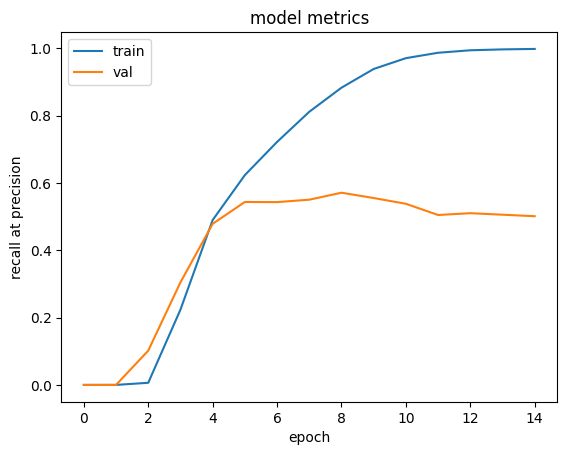

In [261]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

До этого мы разбирали сами слои и как-то не обращали внимание на результаты. А они получаются так себе. Видно, что есть переобучение.

Для борьбы с переобучением в нейронках есть регуляризация и Dropout. 

    Базовая регуляризация тут как в классических алгоритмах - l1 и l2. В большинстве слоев есть параметры smth_regularizer (можно строкой указать l1 или l2), где вместо smth какая-то специфичная часть слоя, которая обучается (kernel_regularizer в свертках  это регуляризация весов в матрицах).
    
    А Dropout - это отдельный слой, в котором часть подаваемых значений просто случайно зануляется. Это застявляет нейронку смотреть  на большее количество паттернов, а не переобучаться только на какой-то один.
 

In [262]:
inputs = keras.layers.Input(shape=(MAX_LEN,))

embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
drop1 = keras.layers.Dropout(0.1)(embeddings)
conv1 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(embeddings)
conv2 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, 
                                               kernel_regularizer='l2',
                                              activation='relu')(conv1)

drop2 = keras.layers.Dropout(0.1)(conv2) # это значит что случайно заменяется половина всех значений

concat = keras.layers.Flatten()(drop2)
dense = keras.layers.Dense(50, activation='relu', kernel_regularizer='l2')(concat)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [263]:
model.summary()

Model: "functional_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_58 (InputLayer)     │ (None, 200)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ embedding_58 (Embedding)        │ (None, 200, 100)          │  2,409,200 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_144 (Conv1D)             │ (None, 196, 32)           │     16,032 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_145 (Conv1D)             │ (None, 192, 32)           │      5,152 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_79 (Dropout)            │ (None, 192, 32)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_57 (Flatten)            │ (None, 6144)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_114 (Dense)               │ (None, 50)                │    307,250 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_115 (Dense)               │ (None, 19)                │        969 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,738,603 (10.45 MB)

 Trainable params: 2,738,603 (10.45 MB)

 Non-trainable params: 0 (0.00 B)

In [264]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=15)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 0.6490 - rec@prec: 4.8702e-05 - val_loss: 0.2120 - val_rec@prec: 0.0000e+00
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 0.2059 - rec@prec: 8.2869e-04 - val_loss: 0.1669 - val_rec@prec: 0.0721
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 0.1772 - rec@prec: 0.0363 - val_loss: 0.1581 - val_rec@prec: 0.2128
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 0.1632 - rec@prec: 0.2568 - val_loss: 0.1714 - val_rec@prec: 0.4495
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 0.1517 - rec@prec: 0.4646 - val_loss: 0.1382 - val_rec@prec: 0.4648
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 0.1216 - rec@prec: 0.5548 - val_loss: 0.1199 - val_rec@prec: 0.4757
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 0.1052 - rec@prec: 0.5971 - val_loss: 0.1315 - val_rec@prec: 0.4270
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 0.1122 - rec@prec: 0.5845 - val_loss: 0.1269 - v

Переобучаться стало сильно меньше.

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


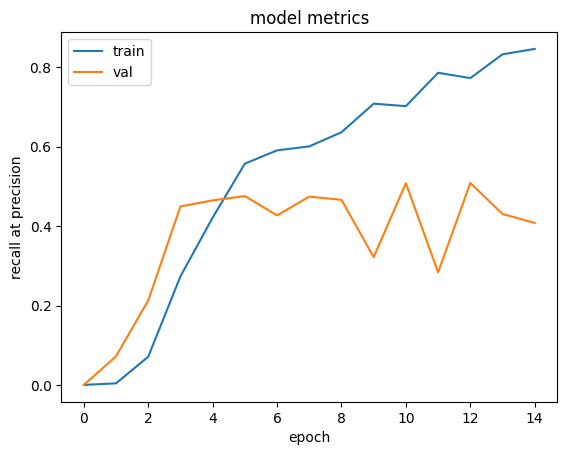

In [265]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Еще один параметр в сверточном слое - padding. Так как мы проходим каким-то окном по последовательности, на выходе последовательность сокращается. Но мы можем добавить нулей в начало и конец, чтобы на выходе было такое же число (padding='same').

Так мы можем наслаивать огромное количество слоев (она не уменьшается на каждом шаге).

А еще это позволяет, например, сделать вот такую сеть:

In [266]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

# мы делаем несколько параллельных сверточных слоев (даже пар слоев с пулингом) с разным окном
# но из-за того, что vы сделали паддинг, длинна получается одинаковая и мы можем сконкатенировать 
# векторы по второй размерности (так же как вы склеивали эбмединги от фастекста и ворд2века в предыдущей домашке)

for ks in [3,4,5,7,10]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)


concat = keras.layers.concatenate(convs, axis=2)

# а тут мы можем поставить еще свертку
conv_global = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = keras.layers.Flatten()(conv_global)
dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [267]:
model.summary()

Model: "functional_117"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_59      │ (None, 200)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embedding_59        │ (None, 200, 100)  │ 2,409,… │ input_layer_59[0][0] │
│ (Embedding)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_146 (Conv1D) │ (None, 200, 32)   │   9,632 │ embedding_59[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_148 (Conv1D) │ (None, 200, 32)   │  12,832 │ embedding_59[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_150 (Conv1D) │ (None, 200, 32)   │  16,032 │ embedding_59[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_152 (Conv1D) │ (None, 200, 32)   │  22,432 │ embedding_59[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_154 (Conv1D) │ (None, 200, 32)   │  32,032 │ embedding_59[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_147 (Conv1D) │ (None, 200, 32)   │   3,104 │ conv1d_146[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_149 (Conv1D) │ (None, 200, 32)   │   4,128 │ conv1d_148[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_151 (Conv1D) │ (None, 200, 32)   │   5,152 │ conv1d_150[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_153 (Conv1D) │ (None, 200, 32)   │   7,200 │ conv1d_152[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_155 (Conv1D) │ (None, 200, 32)   │  10,272 │ conv1d_154[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate_5       │ (None, 200, 160)  │       0 │ conv1d_147[0][0],    │
│ (Concatenate)       │                   │         │ conv1d_149[0][0],    │
│                     │                   │         │ conv1d_151[0][0],    │
│                     │                   │         │ conv1d_153[0][0],    │
│                     │                   │         │ conv1d_155[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_156 (Conv1D) │ (None, 196, 32)   │  25,632 │ concatenate_5[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ flatten_58          │ (None, 6272)      │       0 │ conv1d_156[0][0]     │
│ (Flatten)           │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_116 (Dense)   │ (None, 50)        │ 313,650 │ flatten_58[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_117 (Dense)   │ (None, 19)        │     969 │ dense_116[0][0]      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 2,872,267 (10.96 MB)

 Trainable params: 2,872,267 (10.96 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=20)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 342s 15s/step - loss: 1.5985 - rec@prec: 1.0870e-05 - val_loss: 1.0986 - val_rec@prec: 0.0023
Epoch 2/20
 3/22 ━━━━━━━━━━━━━━━━━━━━ 4:54 15s/step - loss: 1.0872 - rec@prec: 0.0021

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Можно отдельно посмотреть, что делает паддинг в случае тензоров. Есть отдельный слой, который позволяет контролировать, куда и сколько паддить.

In [ ]:
# создадим тензор для примера
# обратите внимание на размерности 
# (batch_size, max_len, embedding_size)
# в нашем случае это можно прочитать как 
# два текста, каждый длинной 3 и размерностью каждого слова 4
input_shape = (2, 3, 4)
x = np.arange(np.prod(input_shape)).reshape(input_shape)
x

Теперь используем `ZeroPadding1D` чтобы добавить по два эмбеддинга с каждой стороны в каждый текст.

In [ ]:
y = keras.layers.ZeroPadding1D(padding=2, )(x)

In [ ]:
# изменилась только размерность max_len (теперь каждый текст это пять эмбеддингов)
y.shape

In [ ]:
# мы добавили по два нулевых эмбединга до и после изначальных эмбеддингов
y

In [ ]:
# через tuple может указать сколько добавить с каждой из сторон
y = keras.layers.ZeroPadding1D(padding=(1,2))(x)

In [ ]:
# также увеличилась только средняя размерность
y.shape

In [ ]:
# один нулевой эмбединг слева (до) и два справа (после)
y

## Сохранение и загрузка модели

Когда какая-то модель получилась, её может потребоваться сохранить.

In [205]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

for ks in [2,3,4,5]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)
concat = keras.layers.concatenate(convs, axis=2)
conv_global = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = keras.layers.Flatten()(conv_global)
dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [206]:
model.save('model.keras')

In [213]:
model = keras.models.load_model('model.keras')

Можно сохранить только веса, но потом придется задать модель и только после этого загрузить веса.

In [208]:
model.save_weights('model.weights.h5')

In [209]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

for ks in [2,3,4,5]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)
concat = keras.layers.concatenate(convs, axis=2)
conv_global = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = keras.layers.Flatten()(conv_global)
dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [210]:
model.load_weights('model.weights.h5')

In [ ]:
keras.Model

## Callbacks

Еще есть такая штука как колбеки. С помощью них можно сохранять модель с лучшим результатом, останавливать обучение, если уже не обучается или менять learning_rate в зависимости от текущего состояния. С колбеками можно поставить нейронку обучаться и заняться какими-то другими делами, зная, что лучшие веса сохранятся.

Описание стандартных колбеков - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

In [214]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла 
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается 
early_stop = keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

In [216]:
inputs = keras.layers.Input(shape=(MAX_LEN,))

embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
drop1 = keras.layers.Dropout(0.3)(embeddings)
conv1 = keras.layers.Conv1D(kernel_size=3, filters=128, strides=1, 
                                               kernel_regularizer='l2',
                                              activation='relu')(embeddings)
conv2 = keras.layers.Conv1D(kernel_size=5, filters=128, strides=2, 
                                               kernel_regularizer='l2',
                                              activation='relu')(conv1)

drop2 = keras.layers.Dropout(0.5)(conv2) # это значит что случайно заменяется половина всех значений

flatten = keras.layers.Flatten()(drop2)
dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [217]:

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10,
         callbacks=[checkpoint, early_stop])

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - loss: 2.1571 - rec@prec: 0.0000e+00 - val_loss: 1.1114 - val_rec@prec: 0.0000e+00
Epoch 2/10


/Users/mnefedov/.pyenv/versions/3.11.7/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:205: UserWarning: Can save best model only with val_f1 available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Users/mnefedov/.pyenv/versions/3.11.7/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_f1` which is not available. Available metrics are: loss,rec@prec,val_loss,val_rec@prec
  current = self.get_monitor_value(logs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - loss: 0.9151 - rec@prec: 0.0000e+00 - val_loss: 0.4847 - val_rec@prec: 0.0000e+00
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - loss: 0.4140 - rec@prec: 1.0870e-06 - val_loss: 0.2612 - val_rec@prec: 0.0000e+00
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - loss: 0.2370 - rec@prec: 4.5181e-04 - val_loss: 0.1832 - val_rec@prec: 0.0180
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - loss: 0.1737 - rec@prec: 0.0197 - val_loss: 0.1481 - val_rec@prec: 0.1353
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - loss: 0.1457 - rec@prec: 0.1723 - val_loss: 0.1309 - val_rec@prec: 0.2340
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - loss: 0.1293 - rec@prec: 0.2792 - val_loss: 0.1246 - val_rec@prec: 0.2795
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - loss: 0.1212 - rec@prec: 0.3300 - val_loss: 0.1180 - val_rec@prec: 0.3147
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - loss: 0.1141 - rec@prec: 0.3985 - val_loss: 0.1191 - val_

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


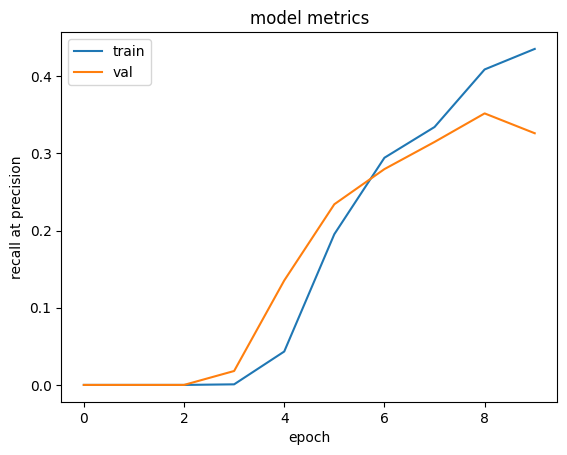

In [218]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()